In [116]:
from src.utils.myPrediction import generate_random_features, customPredictionModel
from src.utils.plots import visLearningCurve
from src.utils.myOptimization import solveGroupProblem, closed_form_group_alpha,\
      AlphaFairnesstorch, solveIndProblem

from src.fairness.cal_fair_penalty import compute_individual_fairness, compute_atkinson_index,\
    compute_group_accuracy_parity, compute_statistical_parity
# ------------------------------------------------------------------
import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
import pandas as pd
from src.utils.features import get_all_features

from torch.utils.data import TensorDataset, DataLoader


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, 'E:\\User\\Stevens\\MyRepo\\FDFL\\helper')
sys.path.insert(0, 'E:\\User\\Stevens\\MyRepo\\fold-opt-package\\fold_opt')

from myutil import *


# Check gradient
# change Learning Rate 
# 

In [117]:
df = pd.read_csv('E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\data\\data.csv')
df = df.sample(n=5000,random_state=1)

# Normalized cost to 0.1-10 range
cost = np.array(df['cost_t_capped'].values).reshape(-1, 1) * 10
cost = np.maximum(cost, 0.1)

# All features, standardized
features = df[get_all_features(df)].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# True benefit, predictor label normalzied to 1-100 range
true_benefit = np.array(df['benefit'].values).reshape(-1, 1) * 100
true_benefit = np.maximum(true_benefit, 1) 

# Group labels, 0 is White (Majority), 1 is Black
race = np.array(df['race'].values).reshape(-1, 1)

In [ ]:
print("True Benefit Statistics:")
print(f"  Mean: {true_benefit.mean():.2f}")
print(f"  Std: {true_benefit.std():.2f}")
print(f"  Min: {true_benefit.min():.2f}")
print(f"  Max: {true_benefit.max():.2f}")

print("\nCost Statistics:")
print(f"  Mean: {cost.mean():.2f}")
print(f"  Std: {cost.std():.2f}")
print(f"  Min: {cost.min():.2f}")
print(f"  Max: {cost.max():.2f}")

True Benefit Statistics:
  Mean: 11.80
  Std: 15.63
  Min: 1.00
  Max: 81.99

Cost Statistics:
  Mean: 0.91
  Std: 1.61
  Min: 0.10
  Max: 10.00


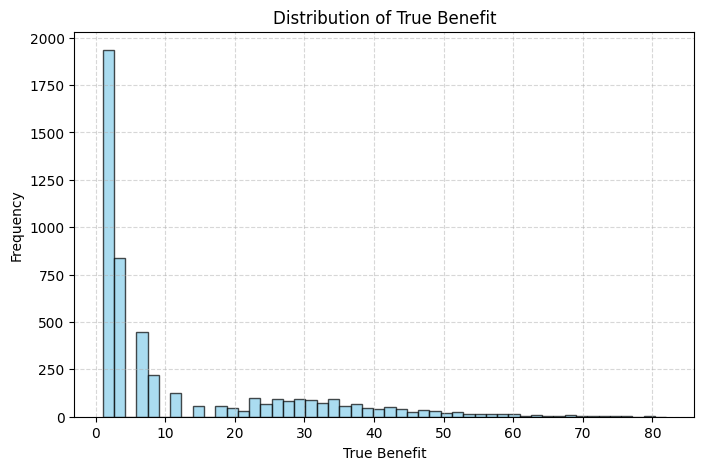

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(true_benefit.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of True Benefit")
plt.xlabel("True Benefit")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

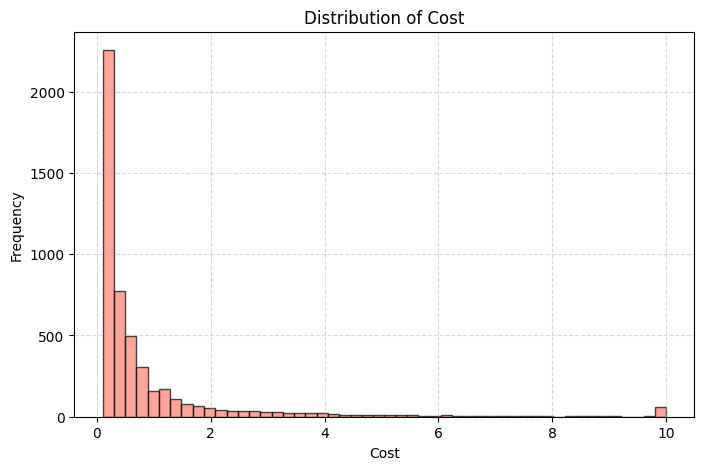

In [143]:
plt.figure(figsize=(8, 5))
plt.hist(cost.flatten(), bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.title("Distribution of Cost")
plt.xlabel("Cost")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Utils

## individual_fairness

In [118]:
def compute_individual_fairness(pred: torch.Tensor,
                                 true: torch.Tensor,
                                 race: torch.Tensor,
                                 d_func=None) -> torch.Tensor:
    """
    Computes individual fairness: similar individuals across groups should receive similar predictions.
    """
    # Flatten everything to 1D
    pred = pred.view(-1)
    true = true.view(-1)
    race = race.view(-1)

    if d_func is None:
        d_func = lambda y1, y2: torch.exp(-(y1 - y2).pow(2))

    mask0 = (race == 0)
    mask1 = (race == 1)

    pred0, pred1 = pred[mask0], pred[mask1]
    true0, true1 = true[mask0], true[mask1]

    n0, n1 = pred0.shape[0], pred1.shape[0]
    if n0 == 0 or n1 == 0:
        return torch.tensor(0.0, device=pred.device)

    pred_diff = pred0.unsqueeze(1) - pred1.unsqueeze(0)       # (n0, n1)
    true_sim = d_func(true0.unsqueeze(1), true1.unsqueeze(0)) # (n0, n1)

    fairness_penalty = (true_sim * pred_diff.pow(2)).mean()
    return fairness_penalty


In [119]:
def compute_statistical_parity(pred: torch.Tensor,
                              race: torch.Tensor) -> torch.Tensor:
    """
    Computes statistical parity: absolute difference in mean predictions between groups.
    """
    pred = pred.view(-1)
    race = race.view(-1)

    mask0 = (race == 0)
    mask1 = (race == 1)

    n0 = mask0.sum().item()
    n1 = mask1.sum().item()
    if n0 == 0 or n1 == 0:
        return torch.tensor(0.0, device=pred.device)

    mean0 = pred[mask0].mean()
    mean1 = pred[mask1].mean()
    stat_parity_penalty = torch.abs(mean0 - mean1)
    return stat_parity_penalty

## group_fairness

In [120]:
def compute_group_accuracy_parity(pred: torch.Tensor,
                                   true: torch.Tensor,
                                   race: torch.Tensor) -> torch.Tensor:
    """
    Computes group fairness as the absolute difference in MSE between two race groups.

    Args:
        pred: Predicted values, shape (n,)
        true: Ground truth values, shape (n,)
        race: Group membership labels (0 or 1), shape (n,)

    Returns:
        fairness_penalty: scalar tensor
    """
    pred = pred.view(-1)
    true = true.view(-1)
    race = race.view(-1)

    mask0 = (race == 0)
    mask1 = (race == 1)

    n0 = mask0.sum().item()
    n1 = mask1.sum().item()
    if n0 == 0 or n1 == 0:
        return torch.tensor(0.0, device=pred.device)

    mse0 = ((pred[mask0] - true[mask0]).pow(2)).mean()
    mse1 = ((pred[mask1] - true[mask1]).pow(2)).mean()
    f_acc = torch.abs(mse0 - mse1)

    return f_acc


## Atkinson's Index

In [121]:
def compute_atkinson_index(pred: torch.Tensor,
                           true: torch.Tensor,
                           beta: float = 0.5) -> torch.Tensor:
    """
    Computes the Atkinson index A on squared errors:
        e_i = (pred_i - true_i)^2  (clamped > 0)
        μ   = mean(e_i)
        U   = mean(e_i^(1-β))                  if β ≠ 1
              exp(mean(log(e_i)))             if β = 1
        A   = 1 – [U^(1/(1-β)) / μ]             if β ≠ 1
              1 – [exp(mean(log(e_i))) / μ]     if β = 1

    Args:
        pred: Predicted values, shape (n,)
        true:  Ground‐truth values, shape (n,)
        beta: Atkinson parameter (β ≥ 0)

    Returns:
        A: scalar Atkinson index in [0,1)
    """
    # flatten
    pred = pred.view(-1)
    true = true.view(-1)

    # squared errors, clamped to avoid zeros
    e = (pred - true).pow(2).clamp_min(1e-12)
    mu = e.mean()

    if abs(beta - 1.0) > 1e-8:
        U = e.pow(1.0 - beta).mean()
        term = U.pow(1.0 / (1.0 - beta))
    else:
        term = torch.exp(torch.log(e).mean())

    A = 1.0 - term / mu
    return A


## Opt Objective(AlphaFairness)

In [122]:
def alpha_fairness_group_utilities(benefit, allocation, group, alpha):
    """
    Compute group-wise alpha-fairness utilities.
    """
    groups = np.unique(group)
    utils = []
    for k in groups:
        mask = (group == k)
        Gk = float(mask.sum())
        # Compute average utility in group k
        util_k = (benefit[mask] * allocation[mask]).sum(axis=0).mean()  # mean total utility per individual in group
        if alpha == 1:
            val = np.log(util_k) if util_k > 0 else -np.inf
        elif alpha == 0:
            val = util_k
        elif alpha == float('inf'):
            # Min utility as min total utility)
            val = (benefit[mask] * allocation[mask]).sum(axis=0).min()
        else:
            val = util_k**(1 - alpha) / (1 - alpha)
        utils.append(val)
    return np.array(utils).sum()

## Prediction Model

In [123]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            # nn.ReLU(),
            # nn.Dropout(dropout_rate),
            # nn.Linear(64, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x)

In [124]:

X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(true_benefit, dtype=torch.float32)
# Split the data, including cost and race
X_train, X_test, y_train, y_test, race_train, race_test, cost_train, cost_test = train_test_split(
    X_tensor, y_tensor, race, torch.tensor(cost, dtype=torch.float32), test_size=0.5, random_state=42
)
gainF = np.ones_like(true_benefit)

## Regret Loss nn.Module

In [125]:
from torch.autograd import Function

class FairRegretLossFunction0(Function):
    @staticmethod
    def forward(ctx, pred_benefit, true_benefit, allocation,cost, 
                group, true_solution, true_objective, alpha, 
                Q, lambda_fairness, fair_reg, grad_method, optmodel):
        """
        Forward pass for the regret loss function.

        inputs:
        - pred_benefit: Tensor of shape (n,)
        - true_benefit: Tensor of shape (n,)
        - allocation: Tensor of shape (n,)
        - cost: Tensor of shape (n,)
        - group: Tensor of shape (n,)
        - true_solution: Tensor of shape (n,)
        - true_objective: Tensor of shape (n,)
        - alpha: float
        - Q: float
        - lambda_fairness: float, fairness penalty weight
        - fair_reg: str
        - grad_method: str, method for computing gradients 
        ('closed_form', 'cvxpylayer', 'finite_difference_2, fold-opt, etc.)
        - optmodel: callable, optimization model function
        outputs:
        - loss: Tensor, the computed regret loss + fairness penalty
        """
        
        pred_benefit_np, true_benefit_np, allocation_np, cost_np,\
        group_np, true_solution_np, true_objective_np = \
        [x.detach().cpu().numpy() for x in [
            pred_benefit, true_benefit, allocation, cost,
            group, true_solution, true_objective
        ]]
        
        # Compute regret
        if optmodel == solveGroupProblem:
            pred_sol, _ = solveGroupProblem(
                pred_benefit_np, cost_np, group_np, alpha, Q
            )
            pred_obj = alpha_fairness_group_utilities(true_benefit_np, allocation,\
                    group_np,alpha)
            loss = true_objective_np - pred_obj
        
        elif optmodel == solve_optimization or optmodel == solve_closed_form: # type:ignore
            pred_sol, _ = optmodel(np.ones_like(pred_benefit_np), pred_benefit_np, cost_np, alpha, Q)
            pred_obj = AlphaFairness(true_benefit_np * allocation_np, alpha) # type: ignore
            loss = true_objective_np - pred_obj
        
        # Compute fairness
        if fair_reg == 'atkinson':
            fair_pen = compute_atkinson_index(pred_benefit_np, true_benefit_np, beta=0.5)
        elif fair_reg == 'stat_parity':
            fair_pen = compute_statistical_parity(pred_benefit_np, true_benefit_np)
        elif fair_reg == 'individual':
            fair_pen = compute_individual_fairness(pred_benefit_np, true_benefit_np, group_np)
        elif fair_reg == 'acc_parity':
            fair_pen = compute_group_accuracy_parity(pred_benefit_np, true_benefit_np, group_np)

        loss = loss + lambda_fairness * fair_pen # type: ignore

        # TODO
        # Add ctx to backward

        return torch.tensor(loss, device=pred_benefit.device)
    @staticmethod
    def backward(ctx, grad_output):
        pass
        


            
            

## Training Function

In [126]:
# ------------------------------------------------------------------
#  Fairness helpers
# ------------------------------------------------------------------
# compute_individual_fairness(pred, true, race)
# compute_group_accuracy_parity(pred, true, race)
# solveGroupProblem(benefit, cost, race, alpha, Q)
# alpha_fairness_group_utilities(benefit, d, race, alpha)

# ------------------------------------------------------------------
#  TRAIN + EVALUATE FUNCTION
# ------------------------------------------------------------------
def train_fair_model_logged(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="none",
        num_epochs=30, lr=1e-2, batch_size=None,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cpu")):
    """
    Train a fairness-aware predictor and log train-loss, test-MSE,
    test-normalised-regret, and test-fairness each epoch.
    """
    # -------------------------- type-check -----------------------------
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_test  = torch.tensor(X_test, dtype=torch.float32)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.tensor(y_train, dtype=torch.float32)
        y_test  = torch.tensor(y_test, dtype=torch.float32)
    if not isinstance(race_train, torch.Tensor):
        race_train = torch.tensor(race_train, dtype=torch.float32)
        race_test  = torch.tensor(race_test, dtype=torch.float32)
    # -------------------------- dataloaders ------------------------
    train_ds = TensorDataset(X_train.to(device), y_train.to(device), race_train.to(device))
    if batch_size is None:
        batch_size = len(train_ds)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # -------------------------- model & opt ------------------------
    model  = model_class(input_dim, dropout_rate=dropout_rate).to(device)
    
    optim  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit   = nn.MSELoss()

    # -------------------------- logs -------------------------------
    loss_log, mse_log, regret_log, fairness_log = [], [], [], []

    # -------------------------- training loop ----------------------
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for x_b, y_b, r_b in train_loader:
            pred_b = model(x_b).squeeze()
            mse    = crit(pred_b, y_b)

            # fairness penalty
            if fairness_type == "individual":
                fair_pen = compute_individual_fairness(pred_b, y_b, r_b)
            elif fairness_type == "acc_parity":
                fair_pen = compute_group_accuracy_parity(pred_b, y_b, r_b)
            elif fairness_type == "stat_parity":
                fair_pen = compute_statistical_parity(pred_b, r_b)
            elif fairness_type == "atkinson":
                fair_pen = compute_atkinson_index(pred_b, y_b)
            else:
                fair_pen = torch.tensor(0.0, device=device)

            loss = mse + lambda_fair * fair_pen
            optim.zero_grad(); loss.backward(); optim.step()
            epoch_loss += loss.item() * x_b.size(0)

        loss_log.append(epoch_loss / len(train_ds))

        # ----------------- evaluation on the held-out set ----------
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test.to(device)).squeeze().cpu()
        mse_val = ((pred_test - y_test).pow(2)).mean().item()
        mse_log.append(mse_val)

        # ensure positivity for optimisation step
        pred_b_np  = pred_test.numpy().reshape(-1, 1)
        pred_b_np  = np.maximum(pred_b_np, 1e-1)

        # regret on test set
        race_np    = race_test.numpy()
        if fairness_type == "acc_parity":

            sol_pred, _,_,_ = closed_form_group_alpha(pred_b_np, cost_test, race_np, alpha=alpha, Q=Q)
            sol_true, _,_,_ = closed_form_group_alpha(y_test, cost_test, race_np, alpha=alpha, Q=Q)
            true_obj    = alpha_fairness_group_utilities(y_test, sol_true, race_np, alpha=alpha)
            pred_obj    = alpha_fairness_group_utilities(y_test, sol_pred, race_np, alpha=alpha)
        
        else:
            b_pred = pred_b_np.flatten()
            b_true = y_test.flatten()
            c_vec = cost_test.flatten()

            # solve the individual problem
            sol_pred_i, _ = solveIndProblem(b_pred, c_vec, alpha=alpha, Q=Q)
            sol_true_i, _ = solveIndProblem(b_true, c_vec, alpha=alpha, Q=Q)

            # build torch‐tensors of utils = benefit * decision
            util_true = torch.tensor(b_true * sol_true_i, dtype=torch.float32, device=device)
            util_pred = torch.tensor(b_true * sol_pred_i, dtype=torch.float32, device=device)

            true_obj = AlphaFairnesstorch(util_true, alpha).item()
            pred_obj = AlphaFairnesstorch(util_pred, alpha).item()
        norm_regret = (true_obj - pred_obj) / (abs(true_obj) + 1e-7)
        regret_log.append(norm_regret)

        # fairness on test set
        if fairness_type == "individual":
            fair_val = compute_individual_fairness(pred_test, y_test, race_test).item()
        elif fairness_type == "acc_parity":
            fair_val = compute_group_accuracy_parity(pred_test, y_test, race_test).item()
        elif fairness_type == "stat_parity":
            fair_val = compute_statistical_parity(pred_test, race_test).item()
        elif fairness_type == "atkinson":
            fair_val = compute_atkinson_index(pred_test, y_test).item()
        else:
            fair_val = None
        fairness_log.append(fair_val)

        # ----------- progress print every 5 epochs -----------------
        if epoch == 1 or epoch % 10 == 0:
            msg = (f"Epoch {epoch:02d}/{num_epochs} | "
                   f"Train-Loss {loss_log[-1]:.4f} | "
                   f"Test-MSE {mse_val:.4f} | Regret {norm_regret:.4f}")
            if fair_val is not None:
                msg += f" | Fair {fair_val:.4f}"
            print(msg)

    # ---------------------- tidy fairness log ---------------------
    if fairness_type == "none":
        fairness_log = None  # keep your plotting function happy

    return model, {"loss_log": loss_log,
                   "mse_log": mse_log,
                   "regret_log": regret_log,
                   "fairness_log": fairness_log}


## Define Alpha & Q

In [151]:
# Save to json
import json
params = {
    "n_sample": 5000 ,
    "alpha": 1.5,
    "Q": 2500,
    "epochs": 100,
    "lambdas": 1.0,
    "lr": 0.01
}

with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_c.json", "w") as f:
    json.dump(params, f, indent=4)

import json

with open("E:\\User\\Stevens\\MyRepo\\Organized-FDFL\\src\\models\\config_c.json", "r") as f:
    params = json.load(f)

n_sample = params["n_sample"]
alpha   = params["alpha"]
Q       = params["Q"]
epochs  = params["epochs"]
lambdas = params["lambdas"]
lr      = params["lr"]


# Training Group (Pred+Opt)

Epoch 01/100 | Train-Loss 667.6418 | Test-MSE 367.0336 | Regret 0.7877 | Fair 202.0673
Epoch 10/100 | Train-Loss 562.0850 | Test-MSE 357.0049 | Regret 0.7971 | Fair 144.1895
Epoch 20/100 | Train-Loss 478.8973 | Test-MSE 351.7237 | Regret 0.7949 | Fair 99.2840
Epoch 30/100 | Train-Loss 437.2503 | Test-MSE 352.7189 | Regret 0.8414 | Fair 75.9644
Epoch 40/100 | Train-Loss 414.2501 | Test-MSE 352.9000 | Regret 0.8393 | Fair 64.6391
Epoch 50/100 | Train-Loss 398.0504 | Test-MSE 351.0222 | Regret 0.4994 | Fair 59.4107
Epoch 60/100 | Train-Loss 386.1694 | Test-MSE 349.1304 | Regret 0.5023 | Fair 56.9901
Epoch 70/100 | Train-Loss 377.0277 | Test-MSE 348.5030 | Regret 0.5050 | Fair 55.3638
Epoch 80/100 | Train-Loss 369.4180 | Test-MSE 348.8781 | Regret 0.5074 | Fair 53.7777
Epoch 90/100 | Train-Loss 362.9050 | Test-MSE 349.6034 | Regret 0.5096 | Fair 52.6301
Epoch 100/100 | Train-Loss 357.1954 | Test-MSE 350.3020 | Regret 0.5117 | Fair 52.0948


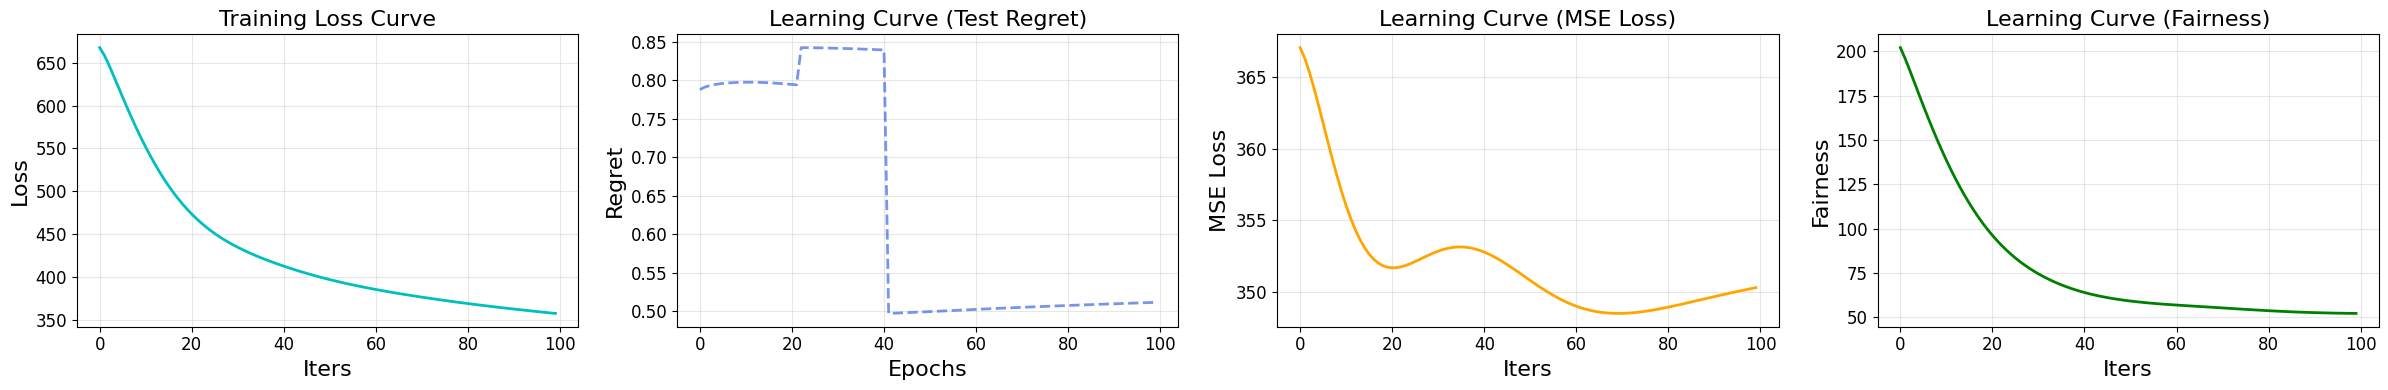

In [148]:
model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="acc_parity", 
    num_epochs=epochs, lr=lr
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


# Training Individual

Epoch 01/100 | Train-Loss 365.1552 | Test-MSE 366.5648 | Regret 0.1123 | Fair 0.0626
Epoch 10/100 | Train-Loss 356.2343 | Test-MSE 357.2219 | Regret 0.2152 | Fair 0.1326
Epoch 20/100 | Train-Loss 337.9736 | Test-MSE 337.8302 | Regret 0.3234 | Fair 0.4086
Epoch 30/100 | Train-Loss 321.0905 | Test-MSE 321.6124 | Regret 0.3972 | Fair 0.7322
Epoch 40/100 | Train-Loss 313.0478 | Test-MSE 314.4255 | Regret 0.4375 | Fair 0.9787
Epoch 50/100 | Train-Loss 309.8191 | Test-MSE 311.5182 | Regret 0.4527 | Fair 1.1372
Epoch 60/100 | Train-Loss 306.8152 | Test-MSE 308.6808 | Regret 0.4516 | Fair 1.2292
Epoch 70/100 | Train-Loss 303.5309 | Test-MSE 305.6736 | Regret 0.4437 | Fair 1.2921
Epoch 80/100 | Train-Loss 300.4127 | Test-MSE 302.8875 | Regret 0.4348 | Fair 1.3531
Epoch 90/100 | Train-Loss 297.3726 | Test-MSE 300.0662 | Regret 0.4317 | Fair 1.4253
Epoch 100/100 | Train-Loss 294.2904 | Test-MSE 297.1938 | Regret 0.4323 | Fair 1.4943


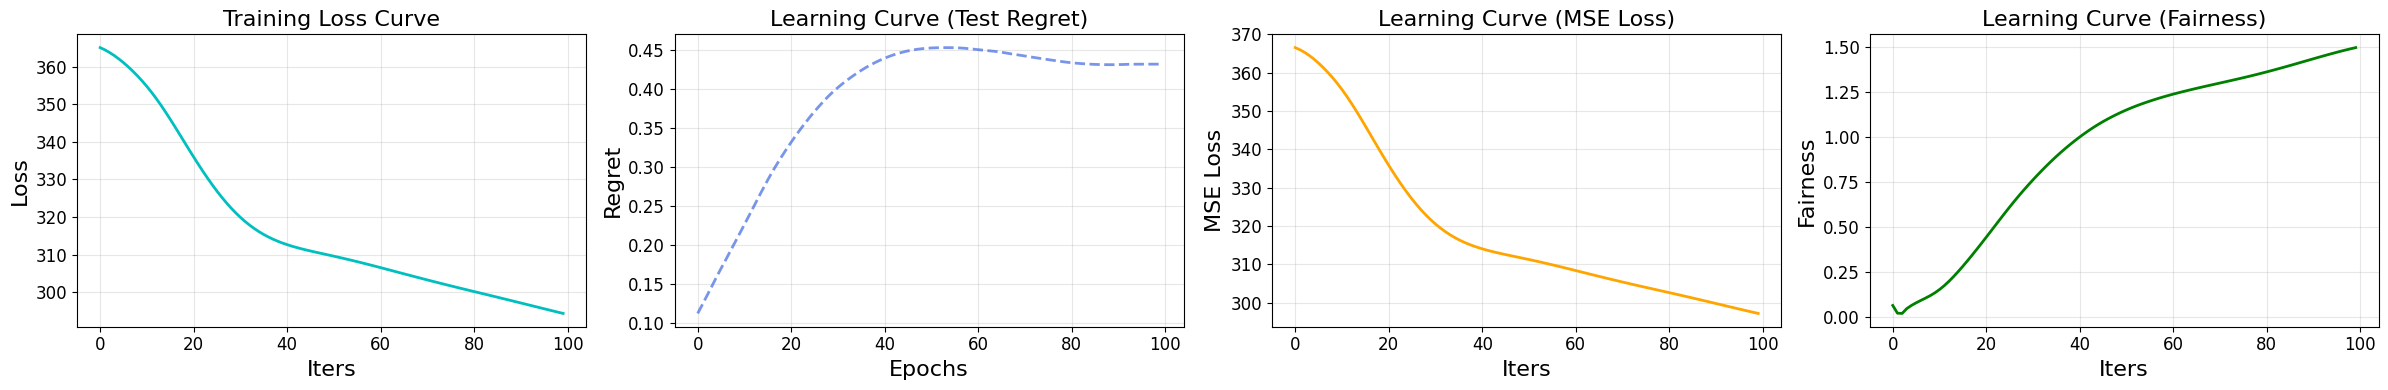

In [149]:


model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="stat_parity", 
    num_epochs=epochs, lr=lr
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


Epoch 01/100 | Train-Loss 365.8638 | Test-MSE 358.8102 | Regret 0.2004 | Fair 0.3296
Epoch 10/100 | Train-Loss 305.7103 | Test-MSE 299.2429 | Regret 0.4772 | Fair 8.1142
Epoch 20/100 | Train-Loss 283.8874 | Test-MSE 283.0391 | Regret 0.4037 | Fair 4.7260
Epoch 30/100 | Train-Loss 273.8597 | Test-MSE 275.3657 | Regret 0.3693 | Fair 3.8341
Epoch 40/100 | Train-Loss 269.2795 | Test-MSE 271.5147 | Regret 0.3689 | Fair 3.7876
Epoch 50/100 | Train-Loss 263.9262 | Test-MSE 266.8554 | Regret 0.3355 | Fair 2.7681
Epoch 60/100 | Train-Loss 261.8279 | Test-MSE 264.3836 | Regret 0.3342 | Fair 2.9130
Epoch 70/100 | Train-Loss 260.6767 | Test-MSE 263.1721 | Regret 0.3300 | Fair 2.7070
Epoch 80/100 | Train-Loss 260.2717 | Test-MSE 262.8260 | Regret 0.3216 | Fair 2.5821
Epoch 90/100 | Train-Loss 259.5995 | Test-MSE 262.2386 | Regret 0.3143 | Fair 2.5029
Epoch 100/100 | Train-Loss 259.1525 | Test-MSE 261.7397 | Regret 0.3150 | Fair 2.4897


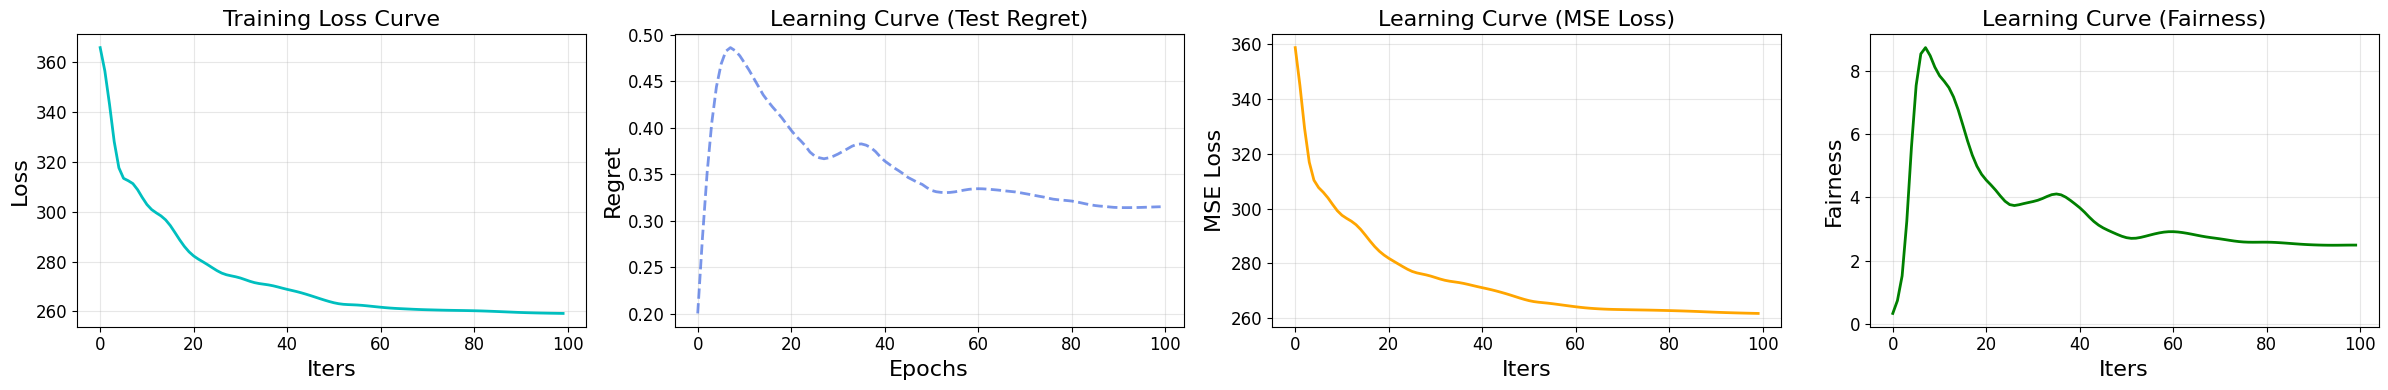

In [150]:

model, logs = train_fair_model_logged(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=lambdas,
    fairness_type="individual",   # 'individual', 'group', or 'none'
    num_epochs=epochs, lr=0.1
)

# -----------------------------------------------------------------
#  Visualise learning curves
# -----------------------------------------------------------------
visLearningCurve(logs["loss_log"],
                 logs["regret_log"],
                 logs["mse_log"],
                 logs["fairness_log"])


# Evaluation

In [115]:
# ------------------------------------------------------------------
#  MULTIPLE-TRIAL TRAINER
# ------------------------------------------------------------------
def train_many_trials(
        X_train, y_train, race_train,
        X_test,  y_test,  race_test,
        cost_test,
        model_class, input_dim,
        alpha, Q,
        lambda_fair=0.0, fairness_type="none",
        num_epochs=30, lr=1e-2, batch_size=None,
        n_trials=10, base_seed=2025,
        dropout_rate=0.1, weight_decay=1e-4,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Run `train_fair_model_logged` for `n_trials` independent seeds and
    return epoch-wise averages of loss, MSE, regret, and fairness.
    """

    # storage: list of dicts, one per trial
    trials_logs = []

    for t in range(n_trials):
        seed = base_seed + t
        torch.manual_seed(seed)
        np.random.seed(seed)

        _, logs = train_fair_model_logged(
            X_train, y_train, race_train,
            X_test,  y_test,  race_test,
            cost_test,
            model_class, input_dim,
            alpha, Q,
            lambda_fair=lambda_fair, # type: ignore
            fairness_type=fairness_type,
            num_epochs=num_epochs,
            lr=lr,
            batch_size=batch_size,
            dropout_rate=dropout_rate,
            weight_decay=weight_decay,
            device=device
        )
        trials_logs.append(logs)

    # ---------- epoch-wise aggregation (mean) ----------------------
    keys = ["loss_log", "mse_log", "regret_log", "fairness_log"]
    avg_logs = {}
    for k in keys:
        # some runs may have fairness_log = None when fairness_type="none"
        if trials_logs[0][k] is None:
            avg_logs[k] = None
            continue
        stack = np.vstack([trial[k] for trial in trials_logs])   # shape: (n_trials, num_epochs)
        avg_logs[k] = stack.mean(axis=0).tolist()                # convert back to list for plotting
        std_k = stack.std(axis=0)[-1]                            # std at final epoch
        mean_k = avg_logs[k][-1]
        print(f"[{k.replace('_log','').upper()}]  final-epoch mean = {mean_k:.4f}  |  std = {std_k:.4f}")

    return avg_logs


In [15]:
avg_logs = train_many_trials(
    X_train, y_train, race_train,
    X_test,  y_test,  race_test,
    cost_test,
    model_class=FairRiskPredictor,
    input_dim=X_train.shape[1],
    alpha=alpha, Q=Q,
    lambda_fair=1.0,
    fairness_type="acc_parity",
    num_epochs=50,
    lr=0.001,
    n_trials=10
)

# Visualise the averaged learning curves
visLearningCurve(avg_logs["loss_log"],
                 avg_logs["regret_log"],
                 avg_logs["mse_log"],
                 avg_logs["fairness_log"])


NameError: name 'train_many_trials' is not defined